In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

# Setup

In [2]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [3]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [4]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [5]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [6]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [7]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [8]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

# Scenario 2

## Cost Functions

In [9]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [10]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [11]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

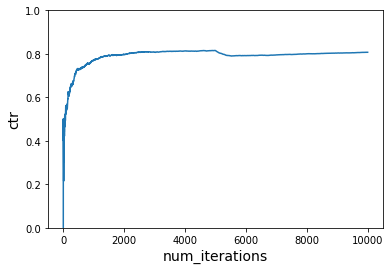

In [12]:
# use first reward function initially, then switch to second reward function, then switch to a new third reward functio

vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000

# adding new cost function
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Modifying Scenario 2

## Add multiple changes to the reward distribution over time

In [13]:
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

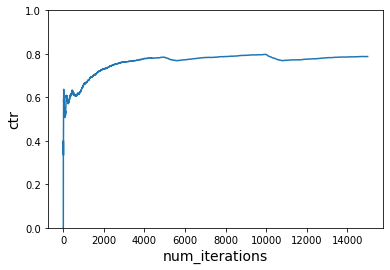

In [14]:
# use first reward function initially, then switch to second reward function, then switch to a new third reward function

vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000

# adding new cost function
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

## Introduce varying noise in the reward distribution

In [15]:
# Preferences
tomPreferences1 = {'morning': {"politics": 1, "sports": .8, "music": .2, "food": 0, "finance": .2, "health": .2, "camping": 0},
                   'afternoon': {"politics": 0, "sports": .2, "music": 1, "food": 0, "finance": 0, "health": .2, "camping": .8}}
annaPreferences1 = {'morning': {"politics": 0, "sports": 1, "music": .6, "food": .3, "finance": 0, "health": .1, "camping": .5},
                    'afternoon': {"politics": 1, "sports": .2, "music": .7, "food": .2, "finance": 0, "health": .4, "camping": 0}}

def get_cost_noise1(context,action):
    if context['user'] == "Tom":
        return tomPreferences1[context['time_of_day']][action] * USER_LIKED_ARTICLE
    elif context['user'] == "Anna":
        return annaPreferences1[context['time_of_day']][action] * USER_LIKED_ARTICLE

In [16]:
"""
Preference Changes:
    Tom's afternoon preferences shifted away from music and camping to sports and finance.
    Anna's afternoon preferences shifted away from music and politics to sports and camping.
"""
tomPreferences2 = {'morning': {"politics": 1, "sports": .8, "music": .2, "food": 0, "finance": .2, "health": .2, "camping": 0},
                   'afternoon': {"politics": 0, "sports": 1, "music": 0, "food": 0, "finance": .5, "health": .2, "camping": .3}}
annaPreferences2 = {'morning': {"politics": 0, "sports": 1, "music": .6, "food": .3, "finance": 0, "health": .1, "camping": .5},
                    'afternoon': {"politics": .2, "sports": 1, "music": .2, "food": .2, "finance": 0, "health": .4, "camping": .5}}

def get_cost_noise2(context, action):
    if context['user'] == "Tom":
        return tomPreferences2[context['time_of_day']][action] * USER_LIKED_ARTICLE
    elif context['user'] == "Anna":
        return annaPreferences2[context['time_of_day']][action] * USER_LIKED_ARTICLE

In [17]:
"""
Preference Changes:
    Tom's and Anna's morning and afternoon preferences swapped.
    Anna's afternoon preferences shifted away from music and politics to sports and camping.
"""
tomPreferences3 = {'morning': {"politics": 0, "sports": 1, "music": 0, "food": 0, "finance": .5, "health": .2, "camping": .3},
                   'afternoon': {"politics": 1, "sports": .8, "music": .2, "food": 0, "finance": .2, "health": .2, "camping": 0}}
annaPreferences3 = {'morning': {"politics": .2, "sports": 1, "music": .2, "food": .2, "finance": 0, "health": .4, "camping": .5},
                    'afternoon': {"politics": 0, "sports": 1, "music": .6, "food": .3, "finance": 0, "health": .1, "camping": .5}}

def get_cost_noise3(context,action):
    if context['user'] == "Tom":
        return tomPreferences3[context['time_of_day']][action] * USER_LIKED_ARTICLE
    elif context['user'] == "Anna":
        return annaPreferences3[context['time_of_day']][action] * USER_LIKED_ARTICLE

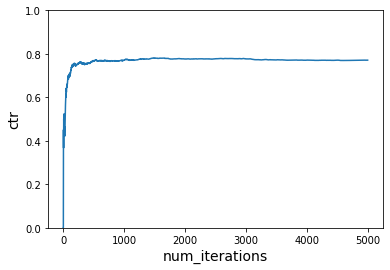

In [18]:
# use first reward function initially, then switch to second reward function, then switch to a new third reward function

vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000

# adding new cost function
cost_functions = [get_cost_noise1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Testing new Simulator

In [19]:
num_iterations_per_cost_func = 5000
cost_functions = [get_cost_noise1, get_cost_noise2, get_cost_noise3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

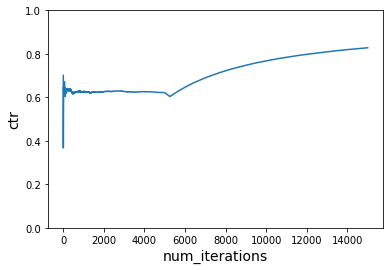

In [20]:
# Explore-first
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 2")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
plot_ctr(total_iterations, ctr)

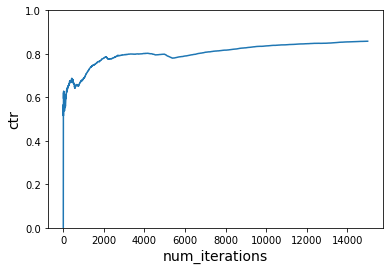

In [21]:
# Epsilon-greedy
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.1")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
plot_ctr(total_iterations, ctr)

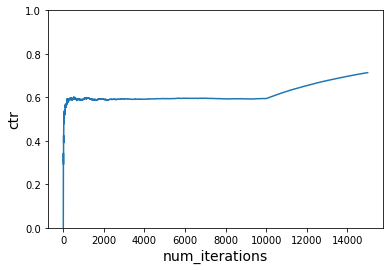

In [22]:
# Bagging Explorer
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
plot_ctr(total_iterations, ctr)

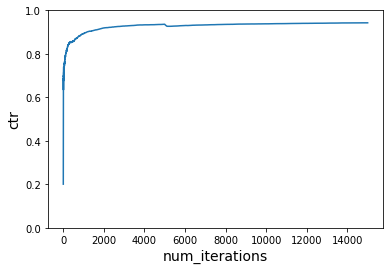

In [23]:
# Softmax Explorer
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
plot_ctr(total_iterations, ctr)

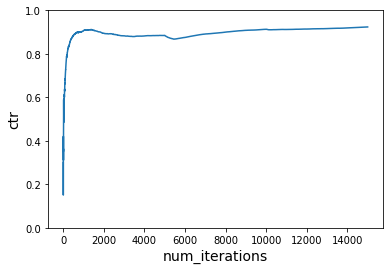

In [24]:
# RND Explorer
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.025")
ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
plot_ctr(total_iterations, ctr)
